In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import patches

import OMADS
from SML.src.SML import FullFactorial, Kriging, LHS # if using the locally cloned SML library
# from SML import FullFactorial, Kriging, LHS # pip install git+https://github.com/Ahmed-Bayoumy/SML.git
from Blackbox_call import Blackbox_call

# Problem definition
We have a blackbox optimization problem of the form

\begin{equation*}
	\begin{aligned}
		& \underset{x_1,x_2}{\text{minimize}}
		& & f(x_1,x_2;\mathbf{p})\\
		& \text{subject to}
		& & g_1(x_1,x_2;\mathbf{p}) \leq 0\\
		& & & g_2(x_1,x_2;\mathbf{p}) \leq 0\\
		& & & g_3(x_1,x_2;\mathbf{p}) \leq 0\\
        & & & -5 \leq x_1 \leq 5\\
        & & & -5 \leq x_2 \leq 5
	\end{aligned}
\end{equation*}

where 
$$
\mathbf{p} = \begin{bmatrix}4 & -4 & -3 & -3 & -3 & 3 & 2 & 0.8 \end{bmatrix}^\mathrm{T}
$$
are fixed parameters. A ``bb.exe`` program is provided in this folder representing the blackbox in question. Its contents are hidden from you and you can only interact with it using the command line

**For Windows**:
```
bb -x 1.0 2.0 -p 4 -4 -3 -3 -3 3 2 0.8 -v
```
**For MACOS/Linux**:
```
./bb -x 1.0 2.0 -p 4 -4 -3 -3 -3 3 2 0.8 -v
```
The blackbox will spit out the following outputs:
```
x = [ 1, 2, ]
p = [ 4, -4, -3, -3, -3, 3, 2, 0.8, ]
f(x): 68, g(x): [ 2 -37 -56.64 ]
```
and will write them to a text file called ``output.txt``.

A wrapper around the blackbox needs to be defined by you first. The wrapper is a Python function that calls the blackbox using the system command line (terminal) and then reads the outputs from ``output.txt`` and returns them. You can then pass this function to any optimization algorithm of your choice.

Such a wrapper is given in the script file [Blackbox_call.py](./Blackbox_call.py).

# Surrogate modeling

We will first try to visualize said blackbox optimization problem since it is a 2D problem. We will use a surrogate model to interpolate the values of the objective iso-contours and constraint boundaries. This step can be skipped for blackboxes in higher dimensions.

For this example, we are using a Kriging model from a library called ``SML`` authored by [Ahmad Bayoumy](https://ahmed-bayoumy.github.io/). We will generate training data using Latin hypercube sampling. 

## Performing a design of experiments (DOE) on the blackbox

First we define the fixed parameters and all the various blackbox options that we need to pass so that it runs

In [2]:
# Problem definition
lb = [-5, -5]
ub = [5, 5]

# p = [8,-4,-3,-3,-3,3,2,0.8] # <---- with these parameters, the constraints are inactive
p = [4,-4,-3,-3,-3,3,2,0.8] # <---- with these parameters, the constraints are active

save_data = True
sur = False
use_gradients = False
sur_model = None

bb_params = {
    "save_data":True,
    "use_surrogate":False,
    "use_gradients":False,
    "parameters":p
} # these are blackbox specific options

Now we loop over the Latin hypercube samples obtained from ``SML``'s ``LHS`` object. You can use any Latin hypercube generator you like.

In [ ]:
new_surrogate = True # toggle to either load an already trained surrogate or to train and save a new one

xfile = "xdata.dat"
yfile = "ydata.dat"
if new_surrogate:
    v = np.array([lb, ub]).T
    n = 40
    sampling = LHS(ns=n, vlim=v)
    sampling.options["criterion"] = "ExactSE"

    xt = sampling.generate_samples()
    yt = np.empty((0,4))
    for i,xi in enumerate(xt):
        f,g = Blackbox_call(xi,bb_params)
        yi = np.array([f, *g]) 
        yt = np.vstack((yt,yi)) # store the blackbox outputs at training outputs

    # save the training data
    np.savetxt(xfile, xt, delimiter=",", header="x1,x2")
    np.savetxt(yfile, yt, delimiter=",", header="f,g1,g2,g3")
    sm = Kriging(type="train", x=xt, y=yt, options={}) # use this to train the model
else:
    # load the training data
    xt = np.loadtxt(xfile, skiprows=1, delimiter=",")
    yt = np.loadtxt(yfile, skiprows=1, delimiter=",")
    sm = Kriging(type="load", xfile=xfile, yfile=yfile, options={}, model_db="model.db") # use this to load a trained model

Now we can plot the objective and constraint boundaries as we have done many times before. We use the surrogate model to get the contour plot values.

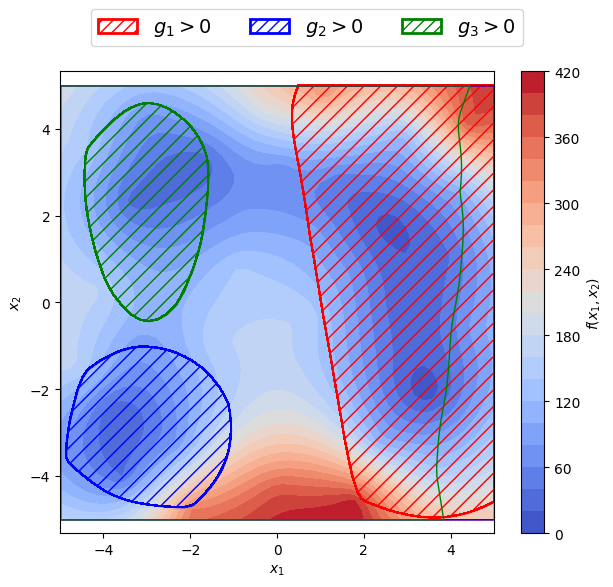

In [4]:
# check surrogate model
def constraint_color(cf,color):
    # https://github.com/matplotlib/matplotlib/issues/2789/#issuecomment-604599060
    for i, collection in enumerate(cf.collections):
        collection.set_edgecolor(color)

n = 50
x1 = np.linspace(lb[0],ub[0],n)
x2 = np.linspace(lb[1],ub[1],n)
X1, X2 = np.meshgrid(x1,x2)
Z = np.ndarray((n, n))

S = np.hstack((np.reshape(X1,(-1,1)), np.reshape(X2,(-1,1))))
sm.x.points = S
sm.predict()
Z = sm.yp.points[:,0].reshape(X1.shape)
G1 = sm.yp.points[:,1].reshape(X1.shape)
G2 = sm.yp.points[:,2].reshape(X1.shape)
G3 = sm.yp.points[:,3].reshape(X1.shape)

fig, ax = plt.subplots(figsize=(7,6))
cf = ax.contourf(X1, X2, Z,cmap="coolwarm",levels=25,zorder=-1)
fig.colorbar(cf, ax=ax, orientation='vertical', label=r"$f(x_1,x_2)$")

handles = []; labels = []
# Constraints
cf = ax.contourf(X1, X2, G1, levels=[-200, 0, 200], colors='none',hatches=[None, '//'],extend='lower')
constraint_color(cf,'r')
a_hatch = patches.Rectangle((20,20), 20, 20, linewidth=2, edgecolor='r', facecolor='none', fill='None', hatch='///')
handles += [a_hatch]
labels += [r"$g_1>0$"]

cf = ax.contourf(X1, X2, G2, levels=[-200, 0, 200], colors='none',hatches=[None, '//'],extend='lower')
constraint_color(cf,'b')
a_hatch = patches.Rectangle((20,20), 20, 20, linewidth=2, edgecolor='b', facecolor='none', fill='None', hatch='///')
handles += [a_hatch]
labels += [r"$g_2>0$"]

cf = ax.contourf(X1, X2, G3, levels=[-200, 0, 200], colors='none',hatches=[None, '//'],extend='lower')
constraint_color(cf,'g')
a_hatch = patches.Rectangle((20,20), 20, 20, linewidth=2, edgecolor='g', facecolor='none', fill='None', hatch='///')
handles += [a_hatch]
labels += [r"$g_3>0$"]

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.axis('equal')
ax.set_xlim((lb[0],ub[0]))
ax.set_ylim((lb[1],ub[1]))
lx = fig.legend(handles, labels, loc='upper center', ncol=3, fontsize = 14)

# Solving the blackbox optimization problem

We solve the blackbox optimization problem using an implementation of Mesh Adaptive Direct Search (MADS) provided by the ``OMADS`` library authored by [Ahmad Bayoumy](https://ahmed-bayoumy.github.io/).

You can find detailed documentation and additional examples on the [``OMADS`` documentation website](https://ahmed-bayoumy.github.io/OMADS/tutorials.html#).

In [5]:
# Optimization setup
x0 = [1.0,2.0]

# we create an empty text file that the blackbox will use to log every call made to it 
# (see how it is being used in Blackbox_call.py)
# you can open this log.txt file after optimization is complete to look at the history of function evaluations
filename = "log.txt"
with open(filename, "w") as file:
    os.utime(filename, None)

# Special blackbox options
bb_params = {
    "save_data":True, # this turns logging on or off
    "use_surrogate":False,
    "use_gradients":False, # the blackbox can optionally return gradients for internally programmed objective and constraints
    "parameters":p,
    "sur_model":sm
}

f,g = Blackbox_call(x0,bb_params) # its a good idea to test the blackbox function first at the initial guess

In [ ]:
eval = {"blackbox": Blackbox_call, 
        "constants": bb_params} # you can pass blackbox specific options using the ``constants`` key
param = {"baseline": x0,
            "lb": lb,
            "ub": ub,
            "var_names": ["x1", "x2"],
            "scaling": 10.0,
            "post_dir": "./post"} # these are OMADS specific options. You can modify them as necessary
options = {"seed": 0, "budget": 100000, "tol": 1e-12, "display": True}

data = {"evaluator": eval, "param": param, "options":options}

out = {}
# out is a dictionary that will hold output data of the final solution. The out dictionary has three keys: "xmin", "fmin" and "hmin"

out = OMADS.main(data)

Now we can postprocess the results and plot the location of the optimizer

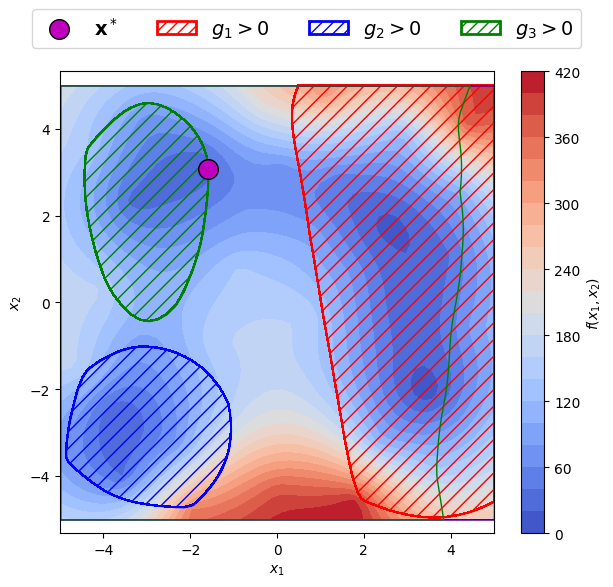

In [7]:
# Plot optimization results
fig, ax = plt.subplots(figsize=(7,6))
cf = ax.contourf(X1, X2, Z,cmap="coolwarm",levels=25,zorder=-1)
fig.colorbar(cf, ax=ax, orientation='vertical', label=r"$f(x_1,x_2)$")

handles = []; labels = []
# optimizer
opt = ax.scatter([out["xmin"][0],], [out["xmin"][1],], s = 200, marker="o", color="m", edgecolors="k", linestyle="None",label="$\mathbf{x}^*$",zorder=3)
handles += [opt]
labels += [r"$\mathbf{x}^*$"]

# Constraints
cf = ax.contourf(X1, X2, G1, levels=[-200, 0, 200], colors='none',hatches=[None, '//'],extend='lower')
constraint_color(cf,'r')
a_hatch = patches.Rectangle((20,20), 20, 20, linewidth=2, edgecolor='r', facecolor='none', fill='None', hatch='///')
handles += [a_hatch]
labels += [r"$g_1>0$"]

cf = ax.contourf(X1, X2, G2, levels=[-200, 0, 200], colors='none',hatches=[None, '//'],extend='lower')
constraint_color(cf,'b')
a_hatch = patches.Rectangle((20,20), 20, 20, linewidth=2, edgecolor='b', facecolor='none', fill='None', hatch='///')
handles += [a_hatch]
labels += [r"$g_2>0$"]

cf = ax.contourf(X1, X2, G3, levels=[-200, 0, 200], colors='none',hatches=[None, '//'],extend='lower')
constraint_color(cf,'g')
a_hatch = patches.Rectangle((20,20), 20, 20, linewidth=2, edgecolor='g', facecolor='none', fill='None', hatch='///')
handles += [a_hatch]
labels += [r"$g_3>0$"]

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.axis('equal')
ax.set_xlim((lb[0],ub[0]))
ax.set_ylim((lb[1],ub[1]))
lx = fig.legend(handles, labels, loc='upper center', ncol=4, fontsize = 14)